In [1]:
# %cd /home/afischer/snakeclef-2024
# ! sudo pip install -r requirements.txt

### Get Image

In [2]:
img_path = '/mnt/data/SnakeCLEF2023-small_size'
img_year = '2023'
img_species = 'Acanthophis_antarcticus'
img_file = '250558438.jpeg'

img_filename = '/'.join([img_path, img_year, img_species, img_file])
img_filename

'/mnt/data/SnakeCLEF2023-small_size/2023/Acanthophis_antarcticus/250558438.jpeg'

(135, 240, 3)


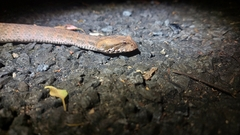

In [3]:
from PIL import Image
import numpy as np

image = Image.open(img_filename)
print(np.asarray(image).shape)
image

### Run SAM

#### Generator

In [4]:
from transformers import pipeline
generator =  pipeline(
    "mask-generation", 
    points_per_batch = 256, 
    # cache_dir='/mnt/data',
    )


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to facebook/sam-vit-huge and revision 997b15 (https://huggingface.co/facebook/sam-vit-huge).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
outputs = generator(image, points_per_batch = 256)
outputs

{'masks': [array([[False, False, False, ..., False, False, False],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, 

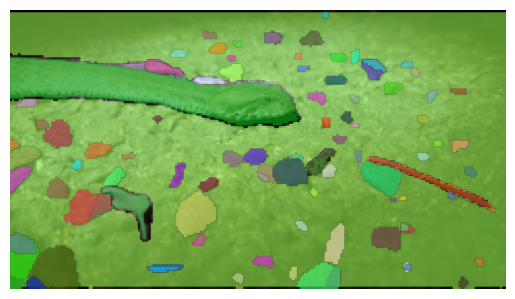

In [6]:
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

plt.imshow(np.array(image))
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()



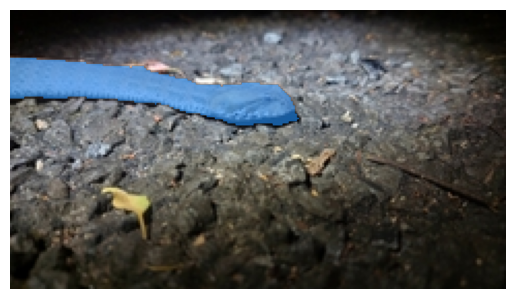

In [17]:
# largest_mask = outputs['masks'][np.argmax([np.sum(m) for m in outputs['masks']])]

areas = [np.sum(m) for m in outputs['masks']]
sorted_indices = np.argsort(areas)  # Sorts and returns the indices
second_largest_index = sorted_indices[-2]  # Get the index of the second largest mask
mask_to_show = outputs['masks'][second_largest_index]

plt.imshow(np.array(image))
ax = plt.gca()
show_mask(mask_to_show, ax=ax)
plt.axis("off")
plt.show()

#### Processor

In [7]:
from transformers import SamModel, SamImageProcessor#, SamProcessor

# model = SamModel.from_pretrained("facebook/sam-vit-base")
# processor = SamImageProcessor.from_pretrained("facebook/sam-vit-base")

In [8]:
inputs = processor(image, return_tensors="pt")
outputs = model(**inputs)

NameError: name 'processor' is not defined

In [ ]:
masks = processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu(), binarize=False)
scores = outputs.iou_scores

### Visualize Masks

In [ ]:
print([m.shape for m in outputs['pred_masks']])
print([m.shape for m in masks])
masks

[torch.Size([1, 3, 256, 256])]
[torch.Size([1, 3, 135, 240])]


[tensor([[[[ -0.3585,  -0.2070,  -0.3821,  ...,  -0.5696,  -0.3479,  -0.5380],
           [  0.2712,   0.4831,   0.3935,  ...,   0.5207,   0.5397,   0.4521],
           [  0.0948,   0.4074,   0.2767,  ...,   0.4996,   0.4277,   0.4191],
           ...,
           [  1.1500,   1.2635,   1.4947,  ...,   1.4822,   1.2983,   1.1779],
           [  0.8570,   1.1037,   1.1442,  ...,   1.5340,   1.2301,   1.2507],
           [  0.3327,   0.4324,   0.5237,  ...,   0.3370,   0.3620,   0.3672]],
 
          [[ -3.1458,  -3.0914,  -3.3683,  ...,  -3.0813,  -3.0468,  -2.8678],
           [ -3.5549,  -4.1048,  -3.5478,  ...,  -3.3577,  -3.1672,  -2.8192],
           [ -3.6526,  -3.3384,  -3.1595,  ...,  -3.3344,  -3.0891,  -2.5699],
           ...,
           [ -0.9795,  -1.1743,  -0.6448,  ...,  -0.9341,  -0.8016,  -0.8354],
           [ -1.3857,  -1.2569,  -1.3394,  ...,  -0.5964,  -1.2246,  -0.6931],
           [ -1.4301,  -1.5673,  -1.5376,  ...,  -1.0460,  -1.1834,  -1.1538]],
 
          [[ -

In [ ]:
outputs 

SamImageSegmentationOutput(iou_scores=tensor([[[0.6438, 0.3930, 0.5234]]], grad_fn=<SliceBackward0>), pred_masks=tensor([[[[[ -0.4305,  -0.2438,  -0.4424,  ...,  -0.6819,  -0.3910,
             -0.6452],
           [  0.2889,   0.5248,   0.4072,  ...,   0.5601,   0.5740,
              0.4662],
           [  0.0366,   0.3878,   0.2502,  ...,   0.4811,   0.3923,
              0.3960],
           ...,
           [ -3.7244,  -3.5596,  -4.6320,  ...,  -2.9463,  -3.5946,
             -3.5919],
           [ -3.0977,  -3.0310,  -3.2258,  ...,  -2.5570,  -2.4045,
             -2.6784],
           [ -2.9007,  -2.8683,  -3.4628,  ...,  -2.4162,  -2.6707,
             -2.9124]],

          [[ -3.1245,  -2.9434,  -3.3525,  ...,  -2.9981,  -3.0415,
             -2.8532],
           [ -3.4923,  -4.3485,  -3.5747,  ...,  -3.2758,  -3.1869,
             -2.8364],
           [ -3.6040,  -3.0977,  -3.0072,  ...,  -3.0156,  -2.9891,
             -2.4195],
           ...,
           [ -6.2943,  -5.9208,  -

In [ ]:
masks[1]

IndexError: list index out of range

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

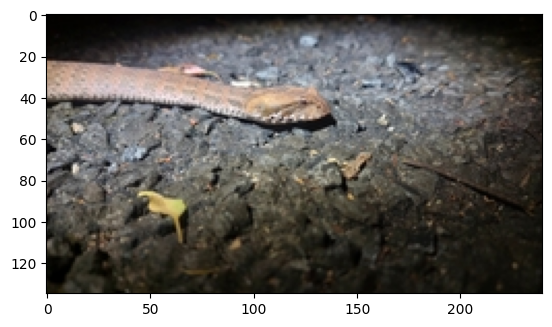

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    # mask_image = mask.reshape(h, w, 3) * color.reshape(1, 1, -1)
    mask_image = mask.reshape(h, w, 3) * color[:3].reshape(1, 1, -1)  # Use only RGB part of color for multiplication
    # mask_image = mask * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

plt.imshow(np.array(image))
ax = plt.gca()
for mask in masks:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

In [ ]:
image.shape

AttributeError: 'JpegImageFile' object has no attribute 'shape'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


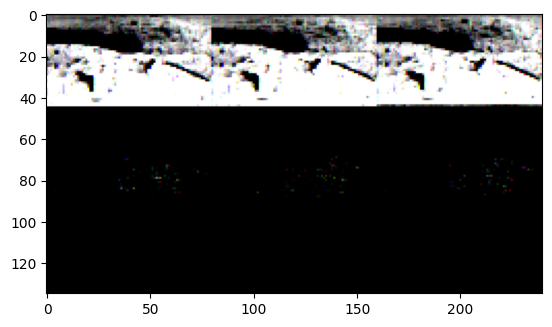

In [ ]:
# plt.imshow(image)

for mask in masks[0]:
    mask = mask.detach()  # Detach the tensor from the computation graph
    # mask.requires_grad_(False)
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 3)
    # mask_image = mask.squeeze()
    plt.imshow(mask_image)